Standard Libraries

In [ ]:
import os
import os.path as osp
import sys
import math
import time

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
sys.path.insert(0,'/content/gdrive/MyDrive/utils')

Mounted at /content/gdrive


In [ ]:
!pip install open3d==0.12.0 # Version 12
#!pip install pypotree #https://github.com/centreborelli/pypotree

3rd Party Libararies

In [ ]:
!pip install pyquaternion
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.
!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.
!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.
!pip install nuscenes-devkit &> /dev/null

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-01-19 08:02:04--  https://www.nuscenes.org/data/v1.0-mini.tgz
Resolving www.nuscenes.org (www.nuscenes.org)... 99.84.192.114, 99.84.192.19, 99.84.192.111, ...
Connecting to www.nuscenes.org (www.nuscenes.org)|99.84.192.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4167696325 (3.9G) [application/x-tar]
Saving to: ‘v1.0-mini.tgz’

v1.0-mini.tgz       100%[===================>]   3.88G   149MB/s    in 23s     

2023-01-19 08:02:28 (171 MB/s) - ‘v1.0-mini.tgz’ saved [4167696325/4167696325]



In [ ]:
import cv2
#import pypotree 
import json
import numpy as np
from pyquaternion import Quaternion
from PIL import Image
from nuscenes.nuscenes import NuScenes
from nuscenes_helper import get_sensor_sample_data
from google.colab.patches import cv2_imshow

Mounted at /content/gdrive


Allow relative imports when being executed as script

In [ ]:
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud, Box, LidarPointCloud
from nuscenes.utils.geometry_utils import box_in_image, view_points, BoxVisibility
from nuscenes.utils.data_classes import PointCloud
import radar
import transform
import nuscenes_helper
from nuscenes.utils.geometry_utils import view_points

Perfomrs resizing of the image and calculates a matrix to adapt the intrinsic camera matrix

In [ ]:

def _resize_image(image_data, target_shape):
    """
    Perfomrs resizing of the image and calculates a matrix to adapt the intrinsic camera matrix
    :param image_data: [np.array] with shape (height x width x 3)
    :param target_shape: [tuple] with (width, height)
    :return resized image: [np.array] with shape (height x width x 3)
    :return resize matrix: [numpy array (3 x 3)]
    """
    # print('resized', type(image_data))
    stupid_confusing_cv2_size_because_width_and_height_are_in_wrong_order = (target_shape[1], target_shape[0])
    resized_image = cv2.resize(image_data, stupid_confusing_cv2_size_because_width_and_height_are_in_wrong_order)
    resize_matrix = np.eye(3, dtype=resized_image.dtype)
    resize_matrix[1, 1] = target_shape[0]/image_data.shape[0]
    resize_matrix[0, 0] = target_shape[1]/image_data.shape[1]
    return resized_image, resize_matrix

This function appends the distance to the radar point.

In [ ]:
def _radar_transformation(radar_data, height=None):
    """
    Transforms the given radar data with height z = 0 and another height as input using extrinsic radar matrix to vehicle's co-sy
    This function appends the distance to the radar point.
    Parameters:
    :param radar_data: [numpy array] with radar parameter (e.g. velocity) in rows and radar points for one timestep in columns
        Semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 distance
    :param radar_extrinsic: [numpy array (3x4)] that consists of the extrinsic parameters of the given radar sensor
    :param height: [tuple] (min height, max height) that defines the (unknown) height of the radar points
    Returns:
    :returns radar_data: [numpy array (m x no of points)] that consists of the transformed radar points with z = 0
    :returns radar_xyz_endpoint: [numpy array (3 x no of points)] that consits of the transformed radar points z = height  
    """

    # Field of view (global)
    ELEVATION_FOV_SR = 20
    ELEVATION_FOV_FR = 14  

    # initialization
    num_points = radar_data.shape[1]

    # Radar points for the endpoint
    radar_xyz_endpoint = radar_data[0:3,:].copy()

    # variant 1: constant height substracted by RADAR_HEIGHT
    RADAR_HEIGHT = 0.5
    if height:
        radar_data[2, :] = np.ones((num_points,)) * (height[0] - RADAR_HEIGHT) # lower points
        radar_xyz_endpoint[2, :] = np.ones((num_points,)) * (height[1] - RADAR_HEIGHT) # upper points
    
    # variant 2: field of view
    else:
        dist = radar_data[-1,:]
        count = 0
        for d in dist:
            # short range mode
            if d <= 70: 
                radar_xyz_endpoint[2, count] = -d * np.tan(ELEVATION_FOV_SR/2)
                
            # long range mode
            else:
                radar_xyz_endpoint[2, count] = -d * np.tan(ELEVATION_FOV_FR/2)

            count += 1

    return radar_data, radar_xyz_endpoint

Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

In [ ]:
def _create_line(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points
    :param P1: [numpy array] that consists of the coordinate of the first point (x,y)
    :param P2: [numpy array] that consists of the coordinate of the second point (x,y)
    :param img: [numpy array] the image being processed
    :return itbuffer: [numpy array] that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y])     
    """
    # define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]

    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    # difference and absolute difference between points
    # used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    # predefine numpy array for output based on distance between points
    itbuffer = np.empty(
        shape=(np.maximum(int(dYa), int(dXa)), 2), dtype=np.float32)
    itbuffer.fill(np.nan)

    # Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X:  # vertical line segment
        itbuffer[:, 0] = P1X
        if negY:
            itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
        else:
            itbuffer[:, 1] = np.arange(P1Y+1, P1Y+dYa+1)
    elif P1Y == P2Y:  # horizontal line segment
        itbuffer[:, 1] = P1Y
        if negX:
            itbuffer[:, 0] = np.arange(P1X-1, P1X-dXa-1, -1)
        else:
            itbuffer[:, 0] = np.arange(P1X+1, P1X+dXa+1)
    else:  # diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:, 1] = np.arange(P1Y-1, P1Y-dYa-1, -1)
            else:
                itbuffer[:, 1] = np.arange(P1Y+1, P1Y+dYa+1)
            itbuffer[:, 0] = (slope*(itbuffer[:, 1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:, 0] = np.arange(P1X-1, P1X-dXa-1, -1)
            else:
                itbuffer[:, 0] = np.arange(P1X+1, P1X+dXa+1)
            itbuffer[:, 1] = (slope*(itbuffer[:, 0]-P1X)).astype(np.int) + P1Y

    # Remove points outside of image
    colX = itbuffer[:, 0].astype(int)
    colY = itbuffer[:, 1].astype(int)
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) &
                        (colX < imageW) & (colY < imageH)]

    return itbuffer

Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

In [ ]:
def _create_vertical_line(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points
    :param P1: [numpy array] that consists of the coordinate of the first point (x,y)
    :param P2: [numpy array] that consists of the coordinate of the second point (x,y)
    :param img: [numpy array] the image being processed
    :return itbuffer: [numpy array] that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y])     
    """
    # define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]

    # difference and absolute difference between points
    # used to calculate slope and relative location between points
    P1_y = int(P1[1])
    P2_y = int(P2[1])
    dX = 0
    dY = P2_y - P1_y
    if dY == 0:
        dY = 1
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    # predefine numpy array for output based on distance between points
    itbuffer = np.empty(
        shape=(np.maximum(int(dYa), int(dXa)), 2), dtype=np.float32)
    itbuffer.fill(np.nan)
    

    # vertical line segment
    itbuffer[:, 0] = int(P1[0])
    if P1_y > P2_y:
        # Obtain coordinates along the line using a form of Bresenham's algorithm
        itbuffer[:, 1] = np.arange(P1_y - 1, P1_y - dYa - 1, -1)
        #cv2.line(img,P1_y,P2_y, (0, 255, 0), thickness=3, lineType=8)

    else:
        itbuffer[:, 1] = np.arange(P1_y+1, P1_y+dYa+1)

    # Remove points outside of image
    colX = itbuffer[:, 0].astype(int)
    colY = itbuffer[:, 1].astype(int)
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) &
                        (colX < imageW) & (colY < imageH)]

    return itbuffer

Calculates a line of two radar points and puts the radar_meta data as additonal layers to the image -> image_plus

In [ ]:
def _radar2camera(image_data, radar_data, radar_xyz_endpoints, clear_radar=True):
    """
    
    Calculates a line of two radar points and puts the radar_meta data as additonal layers to the image -> image_plus
    :param image_data: [numpy array (900 x 1600 x 3)] of image data
    :param radar_data: [numpy array (xyz+meta x no of points)] that consists of the transformed radar points with z = 0
        default semantics: x y z dyn_prop id rcs vx vy vx_comp vy_comp is_quality_valid ambig_state x_rms y_rms invalid_state pdh0 vx_rms vy_rms distance
    :param radar_xyz_endpoints: [numpy array (3 x no of points)] that consits of the transformed radar points z = height
    :param clear_radar: [boolean] True if radar data should be all zero
    :return image_plus: a numpy array (900 x 1600 x (3 + number of radar_meta (e.g. velocity)))
    """

    radar_meta_count = radar_data.shape[0]-3
    radar_extension = np.zeros(
        (image_data.shape[0], image_data.shape[1], radar_meta_count), dtype=np.float32)
    no_of_points = radar_data.shape[1]

    if clear_radar:
        pass # we just don't add it to the image
    else:
        for radar_point in range(0, no_of_points):
            projection_line = _create_vertical_line(
                radar_data[0:2, radar_point], radar_xyz_endpoints[0:2, radar_point], image_data)

            for pixel_point in range(0, projection_line.shape[0]):
                y = projection_line[pixel_point, 1].astype(int)
                x = projection_line[pixel_point, 0].astype(int)

                # Check if pixel is already filled with radar data and overwrite if distance is less than the existing
                if not np.any(radar_extension[y, x]) or radar_data[-1, radar_point] < radar_extension[y, x, -1]:
                    radar_extension[y, x] = radar_data[3:, radar_point]


    image_plus = np.concatenate((image_data, radar_extension), axis=2)

    return image_plus

This is a helper class that maps 3d points to a 2d plane.

In [ ]:
def view_points(points: np.ndarray, view: np.ndarray, normalize: bool):
    """
    This function is a modification of nuscenes.geometry_utils.view_points function
    This is a helper class that maps 3d points to a 2d plane. It can be used to implement both perspective and
    orthographic projections. It first applies the dot product between the points and the view. By convention,
    the view should be such that the data is projected onto the first 2 axis. It then optionally applies a
    normalization along the third dimension.
    For a perspective projection the view should be a 3x3 camera matrix, and normalize=True
    For an orthographic projection with translation the view is a 3x4 matrix and normalize=False
    For an orthographic projection without translation the view is a 3x3 matrix (optionally 3x4 with last columns
     all zeros) and normalize=False
    :param points: <np.float32: 3, n> Matrix of points, where each point (x, y, z) is along each column.
    :param view: <np.float32: n, n>. Defines an arbitrary projection (n <= 4).
        The projection should be such that the corners are projected onto the first 2 axis.
    :param normalize: Whether to normalize the remaining coordinate (along the third axis).
    :return: <np.float32: 3, n>. Mapped point. If normalize=False, the third coordinate is the height.
    """

    output = points

    assert view.shape[0] <= 4
    assert view.shape[1] <= 4
    assert points.shape[0] >= 3
    points = output[0:3,:]

    viewpad = np.eye(4)
    viewpad[:view.shape[0], :view.shape[1]] = view

    nbr_points = points.shape[1]

    # Do operation in homogenous coordinates
    points = np.concatenate((points, np.ones((1, nbr_points))))
    points = np.dot(viewpad, points)
    points = points[:3, :]

    if normalize:
        points = points / points[2:3, :].repeat(3, 0).reshape(3, nbr_points)

    output[0:3,:] = points
    return output

Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image plane

In [ ]:
def map_pointcloud_to_image(nusc, radar_points, pointsensor_token, camera_token, target_resolution=(None,None)):
    """
    Given a point sensor (lidar/radar) token and camera sample_data token, load point-cloud and map it to the image
    plane.
    :param radar_points: [list] list of radar points
    :param pointsensor_token: [str] Lidar/radar sample_data token.
    :param camera_token: [str] Camera sample_data token.
    :param target_resolution: [tuple of int] determining the output size for the radar_image. None for no change
    :return (points <np.float: 2, n)
    """

    # Initialize the database
    cam = nusc.get('sample_data', camera_token)
    pointsensor = nusc.get('sample_data', pointsensor_token)

    pc = RadarPointCloud.from_file(file_name)

    # Points live in the point sensor frame. So they need to be transformed via global to the image plane.
    # First step: transform the point-cloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    pc.translate(np.array(cs_record['translation']))

    # Second step: transform to the global frame.
    poserecord = nusc.get('ego_pose', pointsensor['ego_pose_token'])
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    pc.translate(np.array(poserecord['translation']))

    # Third step: transform into the ego vehicle frame for the timestamp of the image.
    poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    pc.translate(-np.array(poserecord['translation']))
    pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    # Fourth step: transform into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    pc.translate(-np.array(cs_record['translation']))
    pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)

    # Fifth step: actually take a "picture" of the point cloud.
    # Grab the depths (camera frame z axis points away from the camera).

    # intrinsic_resized = np.matmul(camera_resize, np.array(cs_record['camera_intrinsic']))
    view = np.array(cs_record['camera_intrinsic'])
    # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
    points = view_points(pc.points, view, normalize=True) #resize here

    # Resizing to target resolution
    if target_resolution[1]: # resizing width
        points[0,:] *= (target_resolution[1]/cam['width'])

    if target_resolution[0]: # resizing height
        points[1,:] *= (target_resolution[0]/cam['height'])

    # actual_resolution = (cam['height'], cam['width'])
    # for i in range(len(target_resolution)):
    #     if target_resolution[i]:
    #         points[i,:] *= (target_resolution[i]/actual_resolution[i])

    return points

This function turns a radar point cloud into a 1-D array by encoding the spatial information.

In [ ]:
def create_spatial_point_array(nusc, radar_data, pointsensor_token, camera_token, target_width=None):
    """
    This function turns a radar point cloud into a 1-D array by encoding the spatial information.
    The position in the array reflects the direction of the radar point with respect to a camera.
    :param nusc: [nuscenes.nuscenes.Nuscenes] nuScenes database
    :param target_width: [int] the target resolution along x-axis for the output array
    :param dim: dimensionality of the target array
    """
    ##########################
    ##### Initialization #####
    ##########################
    radar_meta_count = radar_data.shape[0] - 3 # -3 for substracting the image positions x y z 
    img_data = nusc.get('sample_data', camera_token)
    target_width = target_width or img_data['width']
    target_resolution = (1, target_width)
    radar_array = np.zeros((*target_resolution, radar_meta_count))

    ######################################
    ##### Perform the array creation #####
    ######################################
    # Get radar points with x and y coordinates
    projected_radar_points = map_pointcloud_to_image(nusc, radar_data, pointsensor_token=pointsensor_token, \
        camera_token=camera_token, target_resolution=target_resolution)

    for i in range(projected_radar_points.shape[1]):
        x,y = projected_radar_points[0:2,i].astype(np.int32) # first 
        if x < 0 or x >= target_width:
            continue # we skip this point, because it lies outside of the image
        y = 0 # Set height to zero in case the point is outside of the image
        radar_array[y,x] = projected_radar_points[3:,i]


    ################################
    ##### Postprocess the data #####
    ################################
    # Remove x,y,z from radar data
    # radar_array = radar_array[3:,:]

    return radar_array

Superordinate function that creates image_plus data of raw camera and radar data

In [ ]:
def imageplus_creation(nusc, image_data, radar_data, pointsensor_token, camera_token, height=(0,3),  \
        image_target_shape=(900, 1600), clear_radar=False, clear_image=False):
    """
    Superordinate function that creates image_plus data of raw camera and radar data
    :param nusc: nuScenes initialization
    :param image_data: [numpy array] (900 x 1600 x 3)
    :param radar_data: [numpy array](SHAPE?) with radar parameter (e.g. velocity) in rows and radar points for one timestep in columns
        Semantics:
            [0]: x (1)
            [1]: y (2)
            [2]: z (3)
            [3]: dyn_prop (4)
            [4]: id (5)
            [5]: rcs (6)
            [6]: vx (7)
            [7]: vy (8)
            [8]: vx_comp (9)
            [9]: vy_comp (10)
            [10]: is_quality_valid (11)
            [11]: ambig_state (12)
            [12]: x_rms (13)
            [13]: y_rms (14)
            [14]: invalid_state (15)
            [15]: pdh0 (16)
            [16]: vx_rms (17)
            [17]: vy_rms (18)
            [18]: distance (19)
    :param pointsensor_token: [str] token of the pointsensor that should be used, most likely radar
    :param camera_token: [str] token of the camera sensor
    :param height: 2 options for 2 different modi
            a.) [tuple] (e.g. height=(0,3)) to define lower and upper boundary
            b.) [str] height = 'FOV' for calculating the heights after the field of view of the radar
    :param image_target_shape: [tuple] with (height, width), default is (900, 1600)
    :param clear_radar: [boolean] True if radar data should be all zero
    :param clear_image: [boolean] True if image data should be all zero
    :returns: [tuple] image_plus, image
        -image_plus: [numpy array] (900 x 1600 x (3 + number of radar_meta (e.g. velocity)))
           Semantics:
            [0]: R (1)
            [1]: G (2)
            [2]: B (3)
            [3]: dyn_prop (4)
            [4]: id (5)
            [5]: rcs (6)
            [6]: vx (7)
            [7]: vy (8)
            [8]: vx_comp (9)
            [9]: vy_comp (10)
            [10]: is_quality_valid (11)
            [11]: ambig_state (12)
            [12]: x_rms (13)
            [13]: y_rms (14)
            [14]: invalid_state (15)
            [15]: pdh0 (16)
            [16]: vx_rms (17)
            [17]: vy_rms (18)
            [18]: distance (19)
        -cur_image: [numpy array] the original, resized image
    """

    ###############################
    ##### Preprocess the data #####
    ###############################
    # enable barcode method
    barcode = False
    if height[1] > 20:
        height = (0,1)
        barcode = True

    # Resize the image due to a target shape
    cur_img, camera_resize = _resize_image(image_data, image_target_shape)

    # Get radar points with the desired height and radar meta data
    radar_points, radar_xyz_endpoint = _radar_transformation(radar_data, height)

    #######################
    ##### Filter Data #####
    #######################
    # Clear the image if clear_image is True
    if clear_image: 
        cur_img.fill(0)
    
    #####################################
    ##### Perform the actual Fusion #####
    #####################################
    # Map the radar points into the image
    radar_points = map_pointcloud_to_image(nusc, radar_points, pointsensor_token=pointsensor_token, camera_token=camera_token, target_resolution=image_target_shape)
    radar_xyz_endpoint = map_pointcloud_to_image(nusc, radar_xyz_endpoint, pointsensor_token=pointsensor_token, camera_token=camera_token, target_resolution=image_target_shape)
    
    if barcode:
        radar_points[1,:] = image_data.shape[0]
        radar_xyz_endpoint[1,:] = 0

    # Create image plus by creating projection lines and store them as additional channels in the image
    image_plus = _radar2camera(cur_img, radar_points, radar_xyz_endpoint, clear_radar=clear_radar)

    #########################
    ##### Quality Check #####
    #########################
    # Check if clear_image worked
    # if clear_image and np.count_nonzero(image_plus[0:3]):
    #     print("Clearing image did not work")
    
    return image_plus

In [ ]:
def imageplus_creation_camra(image_data, radar_data, calibrator, height=(0,3), \
        image_target_shape=(800, 1280)):
    
    ratio = [image_target_shape[0] / image_data.shape[0], image_target_shape[1] / image_data.shape[1]] 
    image_data, _  = _resize_image(image_data, image_target_shape)

    image_data = image_data/255

    x,y,z = radar_data[0:3]
    
    ## Bottom point of projection line
    z = np.ones(x.shape) *(height[0]+0.5)
    
    # radar points according to world2cam convention
    radar_points = [z,y,-x]
    cam_points_low = np.array(calibrator.world2cam(radar_points))
    cam_points_low = np.array([ratio[1] * cam_points_low[0], ratio[0] * cam_points_low[1]]).astype(np.uint16)


    ## Ceiling point of projection line
    z = np.ones(x.shape) *(- height[1] +0.5)
    
    # radar points according to world2cam convention
    radar_points = [z,y,-x]
    cam_points_high = np.array(calibrator.world2cam(radar_points))
    cam_points_high = np.array([ratio[1] * cam_points_high[0], ratio[0] * cam_points_high[1]]).astype(np.uint16)

    # Prevent errors in projection where the high point is lower than the low point
    points_to_keep = cam_points_high[1,:] < cam_points_low[1,:]
    cam_points_high = cam_points_high[:, points_to_keep]
    cam_points_low = cam_points_low[:, points_to_keep]

    
    radar_meta_count = radar_data.shape[0]-3
    radar_extension = np.zeros((image_data.shape[0], image_data.shape[1], radar_meta_count), dtype=np.float32)
    no_of_points = cam_points_low.shape[1]

    for radar_point in range(0, no_of_points):
        projection_line = _create_vertical_line(
            cam_points_low[:, radar_point], cam_points_high[:, radar_point], image_data)

        for pixel_point in range(0, projection_line.shape[0]):
            y = projection_line[pixel_point, 1].astype(int)
            x = projection_line[pixel_point, 0].astype(int)

            # Check if pixel is already filled with radar data and overwrite if distance is less than the existing
            if not np.any(radar_extension[y, x]) or radar_data[-1, radar_point] < radar_extension[y, x, -1]:
                radar_extension[y, x] = radar_data[3:, radar_point]

    image_plus = np.concatenate((image_data, radar_extension), axis=2)
    return image_plus

Visualization of image plus data

In [ ]:
def create_imagep_visualization(image_plus_data, color_channel="vx", \
        draw_circles=True, cfg=True, radar_lines_opacity=2.0):
    """
    Visualization of image plus data
    Parameters:
        :image_plus_data: a numpy array (900 x 1600 x (3 + number of radar_meta (e.g. velocity)))
        :image_data: a numpy array (900 x 1600 x 3)
        :color_channel: <str> Image plus channel for colorizing the radar lines. according to radar.channel_map.
        :draw_circles: Draws circles at the bottom of the radar lines
    Returns:
        :image_data: a numpy array (900 x 1600 x 3)
    """
    # read dimensions
    image_plus_height = image_plus_data.shape[0]
    image_plus_width = image_plus_data.shape[1]
    n_channels = image_plus_data.shape[2]

    ##### Extract the image Channels #####
    if cfg is False:
        image_channels = [0,1,2]
    else:
        image_channels = [i_ch for i_ch in [0,1,2,5,6] if i_ch in [0,1,2]]
    image_data = np.ones(shape=(*image_plus_data.shape[:2],3))
    if len(image_channels) > 0:
        image_data[:,:,image_channels] = image_plus_data[:,:,image_channels].copy() # copy so we dont change the old image

    # Draw the Horizon
    image_data = np.array(image_data*255).astype(np.uint8)
    image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)

    ##### Paint every augmented pixel on the image #####
    if n_channels > 3:
        # transfer it to the currently selected channels
        if cfg is False:
            print("Warning, no cfg provided. Thus, its not possible to find out \
                which channel shall be used for colorization")
            radar_img = np.zeros(image_plus_data.shape[:-1]) # we expect the channel index to be the last axis
        else:
            available_channels = {radar.channel_map[ch]:ch_idx for ch_idx, ch in enumerate([0,1,2,5,6]) if ch > 2}
            ch_idx = available_channels[color_channel]
            # Normalize the radar
            if False: # normalization happens from -127 to 127
                radar_img = image_plus_data[...,ch_idx] + 127.5
            else:
                radar_img = radar.normalize(color_channel, image_plus_data[..., ch_idx],
                                            normalization_interval=[0, 255], sigma_factor=2)

            radar_img = np.clip(radar_img,0,255)

        radar_colormap = np.array(cv2.applyColorMap(radar_img.astype(np.uint8), cv2.COLORMAP_AUTUMN))

        for x in range(0, image_plus_width):
            for y in range(0, image_plus_height):
                radar_channels = image_plus_data[y, x, 3:]
                pixel_contains_radar = np.count_nonzero(radar_channels)
                if not pixel_contains_radar:
                    continue

                radar_color = radar_colormap[y,x]
                for pixel in [(y,x)]: #[(y,x-1),(y,x),(y,x+1)]:
                    if image_data.shape > pixel:
                                
                        # Calculate the color
                        pixel_color = np.array(image_data[pixel][0:3], dtype=np.uint8)
                        pixel_color = np.squeeze(cv2.addWeighted(pixel_color, 1-radar_lines_opacity, radar_color, radar_lines_opacity, 0))

                        # Draw on image
                        image_data[pixel] = pixel_color
                    
                # only if some radar information is there
                if draw_circles:
                    if image_plus_data.shape[0] > y+1 and not np.any(image_plus_data[y+1, x,3:]):
                        cv2.circle(image_data, (x,y), 3, color=radar_colormap[(y,x)].astype(np.float), thickness=3)


    return image_data

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.695 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


<ipython-input-41-4059e12622e8>:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cv2.circle(image_data, (x,y), 3, color=radar_colormap[(y,x)].astype(np.float), thickness=3)


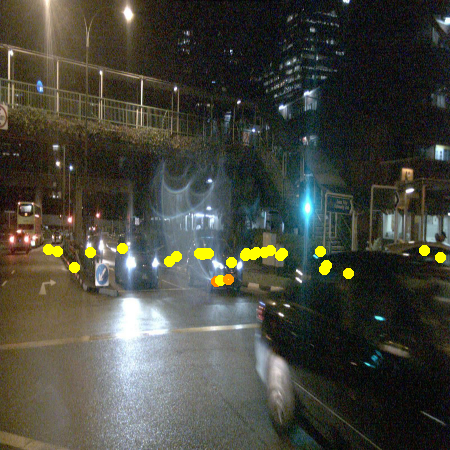

In [ ]:
%matplotlib inline
home =  os.path.expanduser("~")
nusc = NuScenes(version='v1.0-mini', dataroot='/data/sets/nuscenes', verbose=True)

#file_name = "/content/v1.0-mini.tgz"

# Specify sensors to use
radar_channel = 'RADAR_FRONT'
camera_channel = 'CAM_FRONT'

# Get all scene tokens in a list
scene_tokens = [s['token'] for s in nusc.scene]

# Choose a scene token (between 0 and 100)
scene_token = scene_tokens[9]

# Get the first sample of this scene to be demonstrated
scene_rec = nusc.get('scene', scene_token)
sample = nusc.get('sample', scene_rec['first_sample_token'])

# Get the sample token and the records for sensor tokens
sample_token = scene_rec['first_sample_token']
sample_record = nusc.get('sample', sample_token)

# Grab the front camera and the radar sensor.
radar_token = sample_record['data'][radar_channel]
camera_token = sample_record['data'][camera_channel]

# Get radar and image data
radar_data = get_sensor_sample_data(nusc, sample, radar_channel)
image_data = get_sensor_sample_data(nusc, sample, camera_channel)

## Define parameters for image_plus_creation

# Desired image plus shape (resizing)
image_target_shape = (450, 450)

# Desired height for projection lines (2 options)
# ... a.) Tuple (e.g. height=(0,3)) to define lower and upper boundary
# ... b.) height = 'FOV' for calculating the heights after the field of view of the radar
height = (0, 3) #'FOV'

# Call the main function to obtain image_plus_data

sd_rec = nusc.get('sample_data', sample['data'][radar_channel])
file_name = osp.join(nusc.dataroot, sd_rec['filename'])

image_plus_data = imageplus_creation(nusc, image_data, radar_data, radar_token, camera_token, height, image_target_shape, clear_radar=False, clear_image=False)

# Visualize the result
imgp_viz = create_imagep_visualization(image_plus_data)
cv2_imshow(imgp_viz)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
!python3 -m pip install yolov4==2.0.2 # After Checking, YOLO 2.0.2 works without modifying anything. Otherwise keep 1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for yolov4: filename=yolov4-2.0.2-py3-none-any.whl size=39759 sha256=3ae5cda33b450c49c4f8c3bfc838d5c30975b18c25c317e83feb99ab57cc05b2
  Stored in directory: /root/.cache/pip/wheels/84/3b/30/0e98e6b07cb8b73a5022321ed15a29dd660fa595057fec754c
Successfully built yolov4
